# Download data (we use daily data from yahoo)
### We use 8 pairs of currencies for the portfolio
### CADUSD pair as the asset for trading: TRADING_INSTRUMENT = 'CADUSD=X'

#### For currency data, the symbol has the form, e.g. CADUSD=X

In [1]:
import pandas as pd
import numpy as np

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


# Fetch daily data for 4 years, for 7 major currency pairs
TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
        
START_DATE = '2018-01-01'
END_DATE = '2021-12-31'

module 'yfinance' is not installed
     |████████████████████████████████| 63 kB 430 kB/s 
     |████████████████████████████████| 6.4 MB 10.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Visualize each currency pair's prices over the period of our data set
### Scale the JPY/USD pair by 100.0 and CNY/USD by 10 purely for visualization scaling purposes:

[*********************100%***********************]  7 of 7 completed


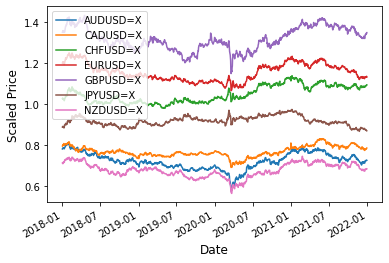

In [2]:
df_orig=yf.download(SYMBOLS, START_DATE, END_DATE)['Close']
df=df_orig
df['JPYUSD=X']=df_orig['JPYUSD=X']*100   

#df.rename(columns={"AUDUSD=X":"AUDUSD",  "GBPUSD=X":"GBPUSD", "CADUSD=X":"CADUSD", "CHFUSD=X":"CHFUSD", \
#                   "EURUSD=X":"EURUSD", "JPYUSD=X":"JPYUSD", "NZDUSD=X":"NZDUSD"}, inplace=True)

df.plot()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Scaled Price', fontsize=12)
plt.legend(prop={'size': 10})
plt.show()


#### Observation: CAD/USD, AUD/USD, and NZD/USD seem to be most correlated, with CHF/USD and JPY/USD being least correlated to CAD/USD

# Define and quantify some parameters we will need to define moving averages, price deviation from moving averages, history of price deviations, and variables to compute and track correlations



## The strategy is described here.
Assume that we are using following $N$ securities $X^1, X^2, \cdots, X^N$ to predict a trading signal for asset $Y$ that we want to trade (TRADING_INSTRUMENT).  The time series of historical data are given by
$$ X^1_1,X^1_2,X^1_3,\cdots , X^1_t$$
$$\vdots$$
$$ X^N_1,X^N_2,X^N_3,\cdots , X^N_t$$
$$ Y_1,Y_2,Y_3,\cdots , Y_t$$

we use $k$ periods in the past to estime the mean, represented by the moving average (sma). To predict the change in the trading instrument $Y$ on day $N$, we use the information from its correlation with the securities $X^1, X^2, \cdots, X^N$.
If we assume that each pair $(Y, X^i$ is jointly normal, then we can use the follwing result:  on day $N$
$$\hat{\Delta Y}(i)_N= \frac{cov(X^i, Y)}{\sigma_{X^i}}\Delta X^i_N$$
where 
$$\Delta X^i_N=X^i_N-E(X^i),      \Delta Y_N(i)=Y_N-E(Y)$$
There are the "projected changes" estimated from its relationship with with $X^i$.

The deviation of projected change from the actual change is when caclulated from asset $i$ is 

$$ \hat{\Delta Y}(i) - \Delta Y$$.

The overall deviation of projected change $\hat{Y}$ from actual change $\Delta Y$ is estimated as a weighted average
$$\hat {\Delta Y}-\Delta Y =\rho_1[\hat {\Delta Y}(1)-\Delta Y]+\cdots + \rho_N [\hat {\Delta Y}(N)-\Delta Y]$$
Where is $\rho_i = corr(Y, X^i)$ (it is divided by $\sum_i\rho_i$ to make the sum equal to 1).


The covariances and correlations are estimated from PRICE_DEV_NUM_PRICES= 200 periods of data 


In [3]:
# Constants/variables that are used to compute simple moving average and price deviation from simple moving average
SMA_NUM_PERIODS = 20  # look back period
price_history = {}  # history of prices

PRICE_DEV_NUM_PRICES = 200 # look back period of ClosePrice deviations from SMA
price_deviation_from_sma = {}  # history of ClosePrice deviations from SMA

# We will use this to iterate over all the days of data we have
num_days = len(df[TRADING_INSTRUMENT].index)

correlation_history = {} # history of correlations per currency pair
change_projected_actual_history = {} # history of differences between Projected ClosePrice deviation and actual ClosePrice deviation per currency pair

final_change_projected_history = [] # history of differences between final Projected ClosePrice deviation for TRADING_INSTRUMENT and actual ClosePrice deviation

# Variables for Trading Strategy trade, position & pnl management:
orders = []  # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = []  # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = []  # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0  # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0  # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0  # Current position of the trading strategy
buy_sum_price_qty = 0  # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0  # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0  # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0  # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0  # Open/Unrealized PnL marked to market
closed_pnl = 0  # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
StatArb_VALUE_FOR_BUY_ENTRY = 0.01  # StatArb trading signal value aboe which to enter buy-orders/long-position
StatArb_VALUE_FOR_SELL_ENTRY = -0.01  # StatArb trading signal value below which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 1000000  # Number of currency to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10  # Minimum Open/Unrealized profit at which to close positions and lock profits


# Quantifying and computing StatArb trading signals
We will see over available prices a day at a time and see what calculations need to be performed, starting with the computation of SimpleMovingAverages and price deviation from the rolling SMA first

In [4]:
import statistics as stats

for i in range(0, num_days):
    close_prices = {}
    # Build ClosePrice series, compute SMA for each symbol and price-deviation from SMA for each symbol
    for symbol in SYMBOLS:
        close_prices[symbol] = df[symbol].iloc[i]
        if not symbol in price_history.keys():
            price_history[symbol] = []
            price_deviation_from_sma[symbol] = []
        price_history[symbol].append(close_prices[symbol])
        if len(price_history[symbol]) > SMA_NUM_PERIODS:  # we track at most SMA_NUM_PERIODS number of prices
            del (price_history[symbol][0])

        sma = stats.mean(price_history[symbol]) # Rolling SimpleMovingAverage based on SMA_NUM_PERIODS observations
        price_deviation_from_sma[symbol].append(close_prices[symbol] - sma) # price deviation from mean
        
        if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
            del (price_deviation_from_sma[symbol][0])                       #use PRICE_DEV_NUM_PRICES observations for prediction

    # Now compute covariance and correlation between TRADING_INSTRUMENT and every other lead symbol
    # also compute projected price deviation and find change between projected and actual price deviations.
    projected_dev_from_sma_using = {}
    for symbol in SYMBOLS:
        if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
            continue
        correlation_label = TRADING_INSTRUMENT + '<-' + symbol
        if correlation_label not in correlation_history.keys(): # first entry for this pair in the history dictionary
            correlation_history[correlation_label] = []
            change_projected_actual_history[correlation_label] = []
        if len(price_deviation_from_sma[symbol]) < 2: # need atleast two observations to compute covariance/correlation
            correlation_history[correlation_label].append(0)
            change_projected_actual_history[correlation_label].append(0)
            continue

        corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
        cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
        corr_trading_instrument_lead_instrument = corr[0, 1]  # get the correlation between the 2 series
        change_trading_instrument_lead_instrument =  cov[0, 1]/cov[1, 1] # use the conditional expectation for multivariate normal distributions

        correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

        #projected-price-deviation-in-TRADING_INSTRUMENT is covariance * price-deviation-in-lead-symbol
        projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1] * change_trading_instrument_lead_instrument

        # change +ve => signal says TRADING_INSTRUMENT price should have moved up more than what it did
        # change -ve => signal says TRADING_INSTRUMENT price should have moved down more than what it did.
        change_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])
        change_projected_actual_history[correlation_label].append(change_projected_actual)

# weigh predictions from each pair, weight is the correlation between those pairs
    sum_weights = 0 # sum of weights is sum of correlations for each symbol with TRADING_INSTRUMENT
    for symbol in SYMBOLS:
        if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
            continue

        correlation_label = TRADING_INSTRUMENT + '<-' + symbol
        sum_weights += abs(correlation_history[correlation_label][-1])

    final_change_projected = 0 # will hold final prediction of price deviation in TRADING_INSTRUMENT, 
                                #weighing projections from all other symbols.
    close_price = close_prices[TRADING_INSTRUMENT]
    for symbol in SYMBOLS:
        if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
            continue

        correlation_label = TRADING_INSTRUMENT + '<-' + symbol

        # We use the correlation as weight to measure the overall price deviation of the assets in the portfolio
        final_change_projected += (abs(correlation_history[correlation_label][-1]) * change_projected_actual_history[correlation_label][-1])

    # normalize by diving by sum of weights for all pairs
    if sum_weights != 0:
        final_change_projected /= sum_weights
    else:
        final_change_projected = 0

    final_change_projected_history.append(final_change_projected)
#####################################################################################################################    
#################################################CHANGE THE CODE ABOVE ##############################################
#####################################################################################################################
    # This section checks trading signal against trading parameters/thresholds and positions, to trade.
    #
    # We will perform a sell trade at close_prices if the following conditions are met:
    # 1. The StatArb trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and current position is profitable enough to lock profit.
    if ((final_change_projected < StatArb_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  # StatArb above sell entry threshold, we should sell
      or (position > 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):  # long from -ve StatArb and StatArb has gone positive or position is profitable, sell to close position
        orders.append(-1)  # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE  # reduce position by the size of this trade
        sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
        print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
    # We will perform a buy trade at close_prices if the following conditions are met:
    # 1. The StatArb trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and current position is profitable enough to lock profit.
    elif ((final_change_projected > StatArb_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  # StatArb below buy entry threshold, we should buy
        or (position < 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))):  # short from +ve StatArb and StatArb has gone negative or position is profitable, buy to close position
        orders.append(+1)  # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE  # increase position by the size of this trade
        buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
        print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
    else:
    # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0:  # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0:  # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    pnls.append(closed_pnl + open_pnl)



Buy  1000000  @  0.7907013297080994 Position:  1000000
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  1000000  @  0.7759095430374146 Position:  2000000
OpenPnL:  -11405.706405639648  ClosedPnL:  0  TotalPnL:  -11405.706405639648
Buy  1000000  @  0.7638252377510071 Position:  3000000
OpenPnL:  -34243.52407455444  ClosedPnL:  0  TotalPnL:  -34243.52407455444
Sell  1000000  @  0.7764879465103149 Position:  2000000
OpenPnL:  6722.450256347545  ClosedPnL:  0  TotalPnL:  6722.450256347545
Sell  1000000  @  0.7840369939804077 Position:  1000000
OpenPnL:  3735.621770222908  ClosedPnL:  0  TotalPnL:  3735.621770222908
Sell  1000000  @  0.7831344604492188 Position:  0
OpenPnL:  14125.823974609264  ClosedPnL:  0  TotalPnL:  14125.823974609264
Sell  1000000  @  0.7872775793075562 Position:  -1000000
OpenPnL:  0  ClosedPnL:  13223.29044342041  TotalPnL:  13223.29044342041
Buy  1000000  @  0.7785736322402954 Position:  0
OpenPnL:  3989.8157119750977  ClosedPnL:  13223.29044342041  TotalPnL:  17213.10

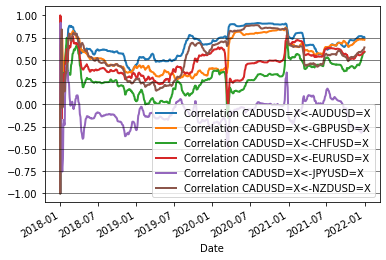

In [5]:
# Plot correlations between TRADING_INSTRUMENT and other currency pairs
correlation_data = pd.DataFrame()
for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:
        continue
    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=df[symbol].index))
    ax = correlation_data['label'].plot(lw=2., label='Correlation ' + correlation_label)

for i in np.arange(-1, 1, 0.25):
    plt.axhline(y=i, lw=0.5, color='k')
plt.legend()
plt.show()


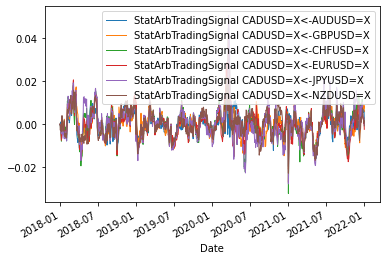

In [6]:
# Plot StatArb signal provided by each currency pair
change_projected_actual_data = pd.DataFrame()
for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:
        continue

    projection_label = TRADING_INSTRUMENT + '<-' + symbol
    change_projected_actual_data = change_projected_actual_data.assign(StatArbTradingSignal=pd.Series(change_projected_actual_history[projection_label], index=df[TRADING_INSTRUMENT].index))
    ax = change_projected_actual_data['StatArbTradingSignal'].plot(lw=1., label='StatArbTradingSignal ' + projection_label)
plt.legend()
plt.show()


### The following plot tells us at what prices the buy and sell trades are made in CADUSD. We will need to inspect the final trading signal in addition to this plot to fully understand the behavior of this StatArb signal and strategy:

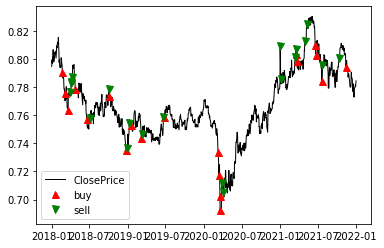

In [7]:
change_projected_actual_data = change_projected_actual_data.assign(ClosePrice=pd.Series(df[TRADING_INSTRUMENT], index=df[TRADING_INSTRUMENT].index))
change_projected_actual_data = change_projected_actual_data.assign(FinalStatArbTradingSignal=pd.Series(final_change_projected_history, index=df[TRADING_INSTRUMENT].index))
change_projected_actual_data = change_projected_actual_data.assign(Trades=pd.Series(orders, index=df[TRADING_INSTRUMENT].index))
change_projected_actual_data = change_projected_actual_data.assign(Position=pd.Series(positions, index=df[TRADING_INSTRUMENT].index))
change_projected_actual_data = change_projected_actual_data.assign(Pnl=pd.Series(pnls, index=df[TRADING_INSTRUMENT].index))

plt.plot(change_projected_actual_data.index, change_projected_actual_data.ClosePrice, color='k', lw=1., label='ClosePrice')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Trades == 1].index, change_projected_actual_data.ClosePrice[change_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Trades == -1].index, change_projected_actual_data.ClosePrice[change_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()


#### Now, let's look at the actual code to build visualization for the final StatArb trading signal, and overlay buy and sell trades over the lifetime of the signal evolution. This will help us understand for what signal values buy and sell trades are made and if that is in line with our expectations:

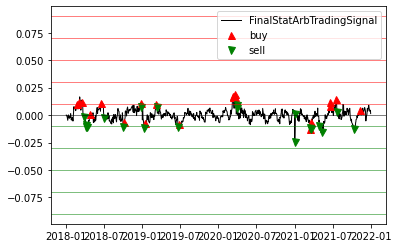

In [8]:
plt.plot(change_projected_actual_data.index, change_projected_actual_data.FinalStatArbTradingSignal, color='k', lw=1., label='FinalStatArbTradingSignal')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Trades == 1].index, change_projected_actual_data.FinalStatArbTradingSignal[change_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Trades == -1].index, change_projected_actual_data.FinalStatArbTradingSignal[change_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in np.arange(StatArb_VALUE_FOR_BUY_ENTRY, StatArb_VALUE_FOR_BUY_ENTRY * 10, StatArb_VALUE_FOR_BUY_ENTRY * 2):
    plt.axhline(y=i, lw=0.5, color='r')
for i in np.arange(StatArb_VALUE_FOR_SELL_ENTRY, StatArb_VALUE_FOR_SELL_ENTRY * 10, StatArb_VALUE_FOR_SELL_ENTRY * 2):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

#### Based on this plot and our understanding of trend-following strategies in addition to the StatArb signal we built, we do indeed see many buy trades when the signal value is positive and sell trades when the signal values are negative. The buy trades made when signal values are negative and sell trades made when signal values are positive can be attributed to the trades that close profitable positions, as we saw in our previous mean reversion and trend-following trading strategies.

### Visualizing the positions and PnLs:

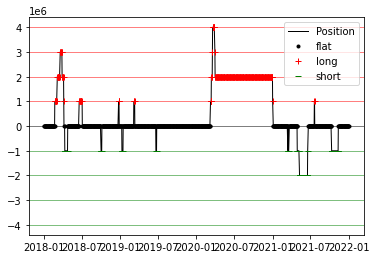

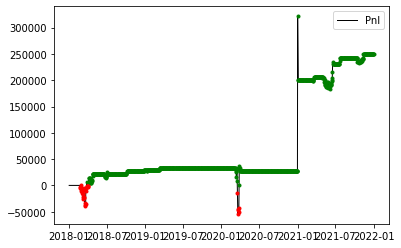

The final PnL is:  249367.41590499878


In [9]:
plt.plot(change_projected_actual_data.index, change_projected_actual_data.Position, color='k', lw=1., label='Position')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Position == 0].index, change_projected_actual_data.Position[change_projected_actual_data.Position == 0], color='k', lw=0, marker='.', label='flat')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Position > 0].index, change_projected_actual_data.Position[change_projected_actual_data.Position > 0], color='r', lw=0, marker='+', label='long')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Position < 0].index, change_projected_actual_data.Position[change_projected_actual_data.Position < 0], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE * 5, NUM_SHARES_PER_TRADE):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE * 5, -NUM_SHARES_PER_TRADE):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()
plt.plot(change_projected_actual_data.index, change_projected_actual_data.Pnl, color='k', lw=1., label='Pnl')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Pnl > 0].index, change_projected_actual_data.Pnl[change_projected_actual_data.Pnl > 0], color='g', lw=0, marker='.')
plt.plot(change_projected_actual_data.loc[change_projected_actual_data.Pnl < 0].index, change_projected_actual_data.Pnl[change_projected_actual_data.Pnl < 0], color='r', lw=0, marker='.')
plt.legend()
plt.show()

print('The final PnL is: ', change_projected_actual_data.Pnl[-1] )
change_projected_actual_data.to_csv("statistical_arbitrage.csv", sep=",")
